# Word Embedding

In [1]:
import torch

## Word2Vec (2013)

[Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/pdf/1301.3781.pdf)

by Tomas Mikolov, Kai Chen, Greg Corrado, and Jeffrey Dean

![](http://i.imgur.com/agTBWiT.png)

### Continuous Bag-Of-Words vs. Skip-gram

* CBOW: guessing the blank
* Skip-gram: guessing the neighbors

![](https://ascelibrary.org/cms/attachment/83d45b70-be2d-4dae-a37a-e3b51af0b7c4/figure3.jpg)

In [2]:
NANO_CORPUS = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells."""

In [3]:
corpus = NANO_CORPUS.lower().replace(',', ' ').replace('.', ' ').split()
print(corpus)

['we', 'are', 'about', 'to', 'study', 'the', 'idea', 'of', 'a', 'computational', 'process', 'computational', 'processes', 'are', 'abstract', 'beings', 'that', 'inhabit', 'computers', 'as', 'they', 'evolve', 'processes', 'manipulate', 'other', 'abstract', 'things', 'called', 'data', 'the', 'evolution', 'of', 'a', 'process', 'is', 'directed', 'by', 'a', 'pattern', 'of', 'rules', 'called', 'a', 'program', 'people', 'create', 'programs', 'to', 'direct', 'processes', 'in', 'effect', 'we', 'conjure', 'the', 'spirits', 'of', 'the', 'computer', 'with', 'our', 'spells']


In [4]:
import pandas as pd

vocabulary = list(set(corpus))
vocabulary

['our',
 'idea',
 'of',
 'are',
 'conjure',
 'we',
 'they',
 'to',
 'computer',
 'spirits',
 'process',
 'people',
 'about',
 'by',
 'the',
 'with',
 'directed',
 'that',
 'inhabit',
 'create',
 'study',
 'evolution',
 'effect',
 'computational',
 'is',
 'processes',
 'computers',
 'evolve',
 'manipulate',
 'other',
 'program',
 'rules',
 'pattern',
 'abstract',
 'beings',
 'called',
 'direct',
 'as',
 'data',
 'spells',
 'things',
 'programs',
 'in',
 'a']

Before we begin anything, we need to create a one-hot vector of the words. Pandas is great at this.

In [5]:
one_hot = pd.get_dummies(vocabulary)
one_hot['about']

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    1
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
40    0
41    0
42    0
43    0
Name: about, dtype: uint8

In [6]:
EMBEDDING_SIZE = 128

class CBOW(torch.nn.Module):
    def __init__(self):
        super(CBOW, self).__init__()
        
        self.embeddings = torch.FloatTensor(len(vocabulary), EMBEDDING_SIZE).normal_()
        self.linear1 = torch.nn.Linear(EMBEDDING_SIZE, 128)
        self.relu1 = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(128, len(vocabulary))
    
    def forward(self, x):
        x = torch.sum(self.embeddings * x.sum(dim=0).view(-1, 1), dim=0) # (4, 44) -> (1, 44) -> (44, 1) -> (128)
        x = self.linear1(x) # (128)
        x = self.relu1(x) # (128)
        x = self.linear2(x) # (44)
        
        return x.view(1, -1) # (1,44)
    
    def get_word_embedding(self, word):
        return self.embeddings[vocabulary.index(word)].view(1, -1)

cbow = CBOW()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cbow.parameters(), lr=0.001)

In [7]:
EPOCHS = 64
WINDOW_SIZE = 2
EMBEDDING_SIZE = 128

def get_context(i, corpus):
    context = []
    
    start = max(i - WINDOW_SIZE, 0)
    end = min(i + WINDOW_SIZE, len(corpus) - 1)
    
    for n in range(start, end):
        if n == i:
            continue
        context.append(corpus[n])
    
    return context

for epoch in range(EPOCHS):
    n_words = 0
    acc_loss = 0
    for i, word in enumerate(corpus):
        context = torch.FloatTensor(
            [one_hot[word] for word in get_context(i, corpus)])
        target = torch.LongTensor([vocabulary.index(word)])

        with torch.set_grad_enabled(True):
            output = cbow(context) # (4, 44) -> (1, 44)
            loss = criterion(output, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            acc_loss += float(loss)
            n_words += 1

    print(f'Epoch {epoch}: loss {acc_loss/n_words:.4f}')

Epoch 0: loss 3.8058
Epoch 1: loss 3.6892
Epoch 2: loss 3.5765
Epoch 3: loss 3.4670
Epoch 4: loss 3.3604
Epoch 5: loss 3.2565
Epoch 6: loss 3.1550
Epoch 7: loss 3.0556
Epoch 8: loss 2.9584
Epoch 9: loss 2.8639
Epoch 10: loss 2.7719
Epoch 11: loss 2.6816
Epoch 12: loss 2.5932
Epoch 13: loss 2.5066
Epoch 14: loss 2.4212
Epoch 15: loss 2.3374
Epoch 16: loss 2.2553
Epoch 17: loss 2.1745
Epoch 18: loss 2.0953
Epoch 19: loss 2.0172
Epoch 20: loss 1.9409
Epoch 21: loss 1.8656
Epoch 22: loss 1.7920
Epoch 23: loss 1.7198
Epoch 24: loss 1.6498
Epoch 25: loss 1.5810
Epoch 26: loss 1.5140
Epoch 27: loss 1.4488
Epoch 28: loss 1.3856
Epoch 29: loss 1.3242
Epoch 30: loss 1.2649
Epoch 31: loss 1.2075
Epoch 32: loss 1.1524
Epoch 33: loss 1.0994
Epoch 34: loss 1.0484
Epoch 35: loss 0.9996
Epoch 36: loss 0.9530
Epoch 37: loss 0.9082
Epoch 38: loss 0.8659
Epoch 39: loss 0.8253
Epoch 40: loss 0.7867
Epoch 41: loss 0.7502
Epoch 42: loss 0.7154
Epoch 43: loss 0.6826
Epoch 44: loss 0.6515
Epoch 45: loss 0.621

Now, remember our corpus?

> We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create **programs** to direct processes. In effect,
we conjure the spirits of the computer with our spells.

Let's see if our model can guess the highlighted word.

In [8]:
quiz = ['people', 'create', 'to', 'direct']
output = cbow(torch.FloatTensor([one_hot[w] for w in quiz]))
_, i = output.max(dim=1)
print(vocabulary[i])

programs


In [9]:
cbow.get_word_embedding('programs')

tensor([[-0.2494, -0.8524, -1.4676,  1.3361, -0.1680,  0.1684, -0.5010,  0.2064,
          0.8753, -0.4601, -1.6704, -0.8172, -1.4150,  0.2076, -0.6401,  2.3908,
         -1.6059, -0.5135,  0.2960,  1.0826, -1.5503,  0.2632,  1.0693,  0.3183,
         -0.8027, -0.3009,  1.3640, -0.8214, -1.6492,  0.6330,  1.1211,  0.2535,
         -0.2682, -0.5037,  0.6543,  0.6882,  1.7919,  0.5456, -0.4440, -1.5784,
          0.9287, -1.2906, -0.5608,  0.2448, -0.0776,  1.0721, -0.6780, -1.0674,
         -1.0782,  0.4239, -1.4042, -0.3490,  0.0364, -1.3333,  0.4569, -0.1449,
          0.1574, -0.1344, -0.3883,  0.3604, -0.0744, -0.7789, -0.0381, -1.2080,
          0.6594,  0.1646, -0.3565, -0.7207,  0.8088,  1.5275,  0.7714,  1.4741,
          2.9597,  0.3867,  0.9447, -1.7460, -0.1983,  0.1776, -0.9087,  2.5315,
         -0.6451, -1.2045, -1.3453, -0.1671,  1.2277, -0.8174,  0.4379, -0.0413,
         -0.2242, -0.8588, -1.0213,  0.9621,  0.5453, -1.8373, -0.7611, -0.4955,
         -0.4116, -0.2585, -

In [10]:
class Skipgram(torch.nn.Module):
    def __init__(self):
        super(Skipgram, self).__init__()
        self.embeddings = torch.FloatTensor(len(vocabulary), EMBEDDING_SIZE).normal_()
        self.linear1 = torch.nn.Linear(EMBEDDING_SIZE, 128)
        self.relu1 = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(128, len(vocabulary))
    
    def forward(self, x):
        x = self.embeddings[x]
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.linear2(x)
        return x.view(1, -1)
    
    def get_word_embedding(self, word):
        return self.embeddings[vocabulary.index(word)].view(1, -1)

skipgram = Skipgram()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(skipgram.parameters(), lr=0.01)

In [11]:
EPOCHS = 64
WINDOW_SIZE = 2
EMBEDDING_SIZE = 128

def get_context(i, corpus):
    context = []
    
    start = max(i - WINDOW_SIZE, 0)
    end = min(i + WINDOW_SIZE, len(corpus) - 1)
    
    for n in range(start, end):
        if n == i:
            continue
        context.append(corpus[n])
    
    return context

for epoch in range(EPOCHS):
    n_words = 0
    acc_loss = 0
    for i, word in enumerate(corpus):
        center = vocabulary.index(word)

        for word in get_context(i, corpus):
            context = torch.LongTensor([vocabulary.index(word)])

            with torch.set_grad_enabled(True):
                output = skipgram(center)
                loss = criterion(output, context)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                acc_loss += float(loss)
                n_words += 1

    print(f'Epoch {epoch}: loss {acc_loss/n_words:.4f}')

Epoch 0: loss 3.7836
Epoch 1: loss 3.4525
Epoch 2: loss 3.1958
Epoch 3: loss 2.9619
Epoch 4: loss 2.7445
Epoch 5: loss 2.5535
Epoch 6: loss 2.3997
Epoch 7: loss 2.2870
Epoch 8: loss 2.2128
Epoch 9: loss 2.1646
Epoch 10: loss 2.1354
Epoch 11: loss 2.1150
Epoch 12: loss 2.1005
Epoch 13: loss 2.0895
Epoch 14: loss 2.0810
Epoch 15: loss 2.0716
Epoch 16: loss 2.0644
Epoch 17: loss 2.0566
Epoch 18: loss 2.0503
Epoch 19: loss 2.0417
Epoch 20: loss 2.0347
Epoch 21: loss 2.0281
Epoch 22: loss 2.0223
Epoch 23: loss 2.0157
Epoch 24: loss 2.0101
Epoch 25: loss 2.0045
Epoch 26: loss 1.9983
Epoch 27: loss 1.9930
Epoch 28: loss 1.9881
Epoch 29: loss 1.9840
Epoch 30: loss 1.9792
Epoch 31: loss 1.9736
Epoch 32: loss 1.9693
Epoch 33: loss 1.9649
Epoch 34: loss 1.9604
Epoch 35: loss 1.9565
Epoch 36: loss 1.9523
Epoch 37: loss 1.9495
Epoch 38: loss 1.9443
Epoch 39: loss 1.9412
Epoch 40: loss 1.9376
Epoch 41: loss 1.9351
Epoch 42: loss 1.9319
Epoch 43: loss 1.9285
Epoch 44: loss 1.9247
Epoch 45: loss 1.922

In [12]:
def get_similar(query, embeddings, top_k=10):
    embeddings = embeddings.cpu()
    query = embeddings[vocabulary.index(query)]
    similarity = (embeddings @ query) / (embeddings.norm() * query.norm())
    similarity = pd.Series(dict(zip(vocabulary, similarity.numpy())))
    similarity = similarity.sort_values(ascending=False)
    
    return similarity[:top_k]

get_similar('computer', skipgram.embeddings)

computer         0.141977
study            0.034313
manipulate       0.029085
by               0.026402
computational    0.025354
inhabit          0.025184
effect           0.023759
as               0.016818
computers        0.014954
directed         0.010654
dtype: float64

## GloVe: Global Vectors for Word Representation (2014)

by Jeffrey Pennington, Richard Socher, Christopher D. Manning

https://www.aclweb.org/anthology/D14-1162

On page 1534:

> We begin with a simple example that showcases
how certain aspects of meaning can be extracted
directly from co-occurrence probabilities. Consider
two words $i$ and $j$ that exhibit a particular aspect
of interest; for concreteness, suppose we are
interested in the concept of thermodynamic phase,
for which we might take $i = ice$ and $j = steam$.
The relationship of these words can be examined
by studying the ratio of their co-occurrence probabilities
with various probe words, $k$. For words
$k$ related to $ice$ but not $steam$, say $k = solid$, we
expect the ratio $Pik / Pjk$ will be large. Similarly,
for words $k$ related to $steam$ but not $ice$, say $k =
gas$, the ratio should be small. For words $k$ like
$water$ or $fashion$, that are either related to both $ice$
and $steam$, or to neither, the ratio should be close
to one. Table 1 shows these probabilities and their
ratios for a large corpus, and the numbers confirm
these expectations. Compared to the raw probabilities,
the ratio is better able to distinguish relevant
words ($solid$ and $gas$) from irrelevant words ($water$
and $fashion$) and it is also better able to discriminate
between the two relevant words.

$$
\frac{P_{solid | ice}}{P_{solid | steam}} >
\frac{P_{fashion | ice}}{P_{fashion | steam}} >
\frac{P_{gas | ice}}{P_{gas | steam}}
$$

> The above argument suggests that the appropriate
starting point for word vector learning should
be with ratios of co-occurrence probabilities rather
than the probabilities themselves. Noting that the
ratio $P_{ik} /P_{jk}$ depends on three words $i$, $j$, and $k$,
the most general model takes the form,

$$
F(w_i, w_j, \tilde{w}_k) = \frac{P_{ik}}{P_{jk}}
$$

> The number of possibilities for $F$ is vast,
but by enforcing a few desiderata we can select a
unique choice. First, we would like $F$ to encode
the information present the ratio $Pik / Pjk$ in the
word vector space. Since vector spaces are inherently
linear structures, the most natural way to do
this is with vector differences.

$$
F(w_i - w_j, \tilde{w}_k) = \frac{P_{ik}}{P_{jk}}
$$

> Next, we note that the arguments of $F$ in Eqn. (2)
are vectors while the right-hand side is a scalar.
While $F$ could be taken to be a complicated function
parameterized by, e.g., a neural network, doing
so would obfuscate the linear structure we are
trying to capture. To avoid this issue, we can first
take the dot product of the arguments,

$$
F((w_i - w_j)^T \tilde{w}_k) = \frac{P_{ik}}{P_{jk}}
$$

> Next, note that for
word-word co-occurrence matrices, the distinction
between a word and a context word is arbitrary and
that we are free to exchange the two roles. To do so
consistently, we must not only exchange $w \leftrightarrow \tilde{w}$
but also $X \leftrightarrow X^T$. Our final model should be invariant
under this relabeling, but Eqn. (3) is not.
However, the symmetry can be restored in two
steps. First, we require that $F$ be a homomorphism
between the groups $(\mathbb{R}, +)$ and $(\mathbb{R}_{>0}, \times)$, i.e.,

$$
F(X-Y)=\frac { F(X) }{ F(Y) }
$$

$$
F(w_i^T \tilde{w}_k - w_j^T \tilde{w}_k) = \frac{P_{ik}}{P_{jk}}
$$

$$
F(w_i^T \tilde{w}_k - w_j^T \tilde{w}_k) = \frac{F(w_i^T \tilde{w}_k)}{F(w_j^T \tilde{w}_k)}
$$

$$
\exp(w_i^T \tilde{w}_k - w_j^T \tilde{w}_k) = \frac{\exp(w_i^T \tilde{w}_k)}{\exp(w_j^T \tilde{w}_k)}
$$

$$F = \exp$$

Page 1533:
> Let the matrix
of word-word co-occurrence counts be denoted by
$X$, whose entries $X_{ij}$ tabulate the number of times
word $j$ occurs in the context of word $i$. Let $X_i = \sum_k X_{ik}$
be the number of times any word appears
in the context of word $i$. Finally, let
$P_{ij} = P(j|i) = X_{ij}/X_i$be the probability that word $j$ appear in the
context of word $i$.

$$
F(w_i^T \tilde{w}_k) = P_{ik} = \frac{X_{ik}}{X_i}
$$

$$
w_i^T \tilde { w }_k =\log { { P }_{ ik } } =\log ({ X_{ ik })-\log ({ X_{ i } })  }
$$

Page 1535:
> Next, we note that Eqn. (6) would exhibit the exchange
symmetry if not for the $log(X_i)$ on the
right-hand side. 

$$
\log(X_{ik})-\log(X_i) \neq \log(X_{ki})-\log(X_k)
$$

> However, this term is independent
of $k$ so it can be absorbed into a bias $b_i$ for
$w+i$. Finally, adding an additional bias $\tilde{b}_k$ for $\tilde{w}_k$
restores the symmetry,

$$
{ w }_{ i }^{ T }\tilde { { w }_{ k } } +{ b }_{ i }+\tilde { { b }_{ k } } =\log ({ X_{ ik }})
$$

## Building the vocabulary and counting co-occurrence (again)

Today's dataset, an English monolingual corpus, can be found [here](https://drive.google.com/open?id=1__lK0x_k8gtyV27QZqQUGSC4jlaQAZSC).

In [13]:
from collections import defaultdict

FILE = 'ted.en.txt'
WINDOW_SIZE = 10

vocabulary = defaultdict(int)
co_occurrence = defaultdict(int)

with open(FILE) as f:
    sentences = f.readlines()

for sentence in sentences:
    words = sentence.split(' ')
    for i in range(len(words)):
        vocabulary[words[i]] += 1

        for j in range(i + 1, i + WINDOW_SIZE + 1):
            if j >= len(words):
                break
            keys = tuple(sorted([words[i], words[j]]))
            co_occurrence[keys] += 1

Let's see how much words we have gathered.

In [14]:
len(vocabulary)

77599

Show some love!

In [15]:
'love' in vocabulary

True

How much?

In [16]:
vocabulary['love']

2444

Let's convert the dictionary into a Pandas Series for convinience.

In [17]:
import pandas as pd

MIN_OCCURRENCE = 10

vocabulary = pd.Series(vocabulary, dtype='uint16')

And with the help of Pandas, let's set a minimum frequency threshold to trim the vocabulary.

In [18]:
vocabulary = vocabulary[vocabulary >= MIN_OCCURRENCE]
len(vocabulary)

16754

In [19]:
'love' in vocabulary

True

In [20]:
import numpy as np

X_ij = np.zeros((len(vocabulary), len(vocabulary)), dtype='uint16')

for (word_i, word_j), value in co_occurrence.items():
    try:
        i = vocabulary.index.get_loc(word_i)
        j = vocabulary.index.get_loc(word_j)
    except KeyError:
        continue

    X_ij[i][j] = value
    X_ij[j][i] = value

In [21]:
X_ij

array([[  28, 2145,    3, ...,    0,    0,    0],
       [2145, 5716,   49, ...,    4,    0,    4],
       [   3,   49,    2, ...,    0,    0,    0],
       ...,
       [   0,    4,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    4,    0, ...,    0,    0,    0]], dtype=uint16)

$$
{ w }_{ i }^{ T }\tilde { { w }_{ k } } +{ b }_{ i }+\tilde { { b }_{ k } } =\log ({ X_{ ik }})
$$

In [22]:
from itertools import chain
import torch

DIM = 128
ITERATIONS = 32
X_MAX = 100
ALPHA = 3/4
GPU_ID = 2

n_words = X_ij.shape[0]

X = torch.from_numpy(X_ij.astype('float32')).add_(1)
w_main = torch.FloatTensor(n_words, DIM).uniform_(-0.5, 0.5)
w_context = torch.FloatTensor(n_words, DIM).uniform_(-0.5, 0.5)
b_main = torch.FloatTensor(n_words).uniform_(-0.5, 0.5)
b_context = torch.FloatTensor(n_words).uniform_(-0.5, 0.5)

if torch.cuda.is_available():
    X = X.cuda(device=GPU_ID)
    w_main = w_main.cuda(device=GPU_ID)
    w_context = w_context.cuda(device=GPU_ID)
    b_main = b_main.cuda(device=GPU_ID)
    b_context = b_context.cuda(device=GPU_ID)

X.requires_grad_(False)
w_main.requires_grad_(True)
w_context.requires_grad_(True)
b_main.requires_grad_(True)
b_context.requires_grad_(True)

criterion = torch.nn.MSELoss(reduction='none')
optimizer = torch.optim.Adam([w_main, w_context, b_main, b_context],
                             lr=1e-3, weight_decay=1e-15)

with torch.set_grad_enabled(True):
    for iteration in range(ITERATIONS):
        acc_loss = 0
        for j in torch.randperm(n_words):
            output = w_main @ w_context[j]
            output += b_main
            output += b_context[j]
            
            loss = criterion(output, X[:, j].log() + 1e-15)
            
            loss_weight = (X[:, j] / X_MAX) ** ALPHA
            loss_weight[X[:, j] > X_MAX] = 1

            optimizer.zero_grad()
            loss.backward(loss_weight)
            optimizer.step()
            
            acc_loss += float(loss.mean())
        
        print(f'iteration {iteration}, loss {acc_loss/n_words:.4f}')

iteration 0, loss 0.2806
iteration 1, loss 0.1483
iteration 2, loss 0.0937
iteration 3, loss 0.0682
iteration 4, loss 0.0573
iteration 5, loss 0.0503
iteration 6, loss 0.0487
iteration 7, loss 0.0441
iteration 8, loss 0.0428
iteration 9, loss 0.0406
iteration 10, loss 0.0393
iteration 11, loss 0.0370
iteration 12, loss 0.0354
iteration 13, loss 0.0343
iteration 14, loss 0.0327
iteration 15, loss 0.0323
iteration 16, loss 0.0314
iteration 17, loss 0.0312
iteration 18, loss 0.0306
iteration 19, loss 0.0299
iteration 20, loss 0.0294
iteration 21, loss 0.0292
iteration 22, loss 0.0286
iteration 23, loss 0.0284
iteration 24, loss 0.0280
iteration 25, loss 0.0275
iteration 26, loss 0.0274
iteration 27, loss 0.0271
iteration 28, loss 0.0272
iteration 29, loss 0.0269
iteration 30, loss 0.0268
iteration 31, loss 0.0264


In [ ]:
def v(word):
    i = vocabulary.index.get_loc(word)
    return w_main[i].cpu()

def analogy(target, top_k=20):
    target /= target.norm()
    
    with torch.no_grad():
        similarity = (w_main.cpu() @ target) / (w_main.cpu().norm() * target.norm())
        similarity = pd.Series(dict(zip(vocabulary.keys(), similarity.numpy())))
        similarity = similarity[vocabulary < 500]
        similarity = similarity.sort_values(ascending=False)
    
    return similarity.sort_values(ascending=False)[:top_k]

analogy(v('husband') - v('man') + v('woman'))

wife        0.012095
mom         0.011205
son         0.010958
husband     0.010791
married     0.010523
daughter    0.010520
college     0.010492
sister      0.010340
brother     0.010319
11          0.010012
named       0.009955
boy         0.009892
walked      0.009806
sent        0.009751
month       0.009650
sat         0.009608
loved       0.009501
killed      0.009443
student     0.009430
hour        0.009417
dtype: float64

In [ ]:
analogy(v('heaven') - v('good') + v('bad'))

brother     0.006279
walked      0.005916
wife        0.005880
sat         0.005814
sister      0.005785
door        0.005644
named       0.005607
son         0.005583
picked      0.005571
mom         0.005510
daughter    0.005475
nose        0.005389
husband     0.005357
floor       0.005326
mouth       0.005316
ran         0.005274
north       0.005255
neck        0.005255
bought      0.005237
Street      0.005210
dtype: float64

## Visualization using PCA and t-SNE

![](https://scontent-icn1-1.xx.fbcdn.net/v/t1.0-9/41425661_1809264752526756_3946431284045152256_n.jpg?_nc_cat=107&oh=e0b118959eaf0d6c7c97ce71b8c1136d&oe=5C20EDF1)

* PCA
  * good for dimensionality reduction
  * not always good for visualization
  * weak against non-linear data
* t-SNE
  * good for visualization
  * not so good for dimensionality reduction
  * strong against non-linear data

[FastText](https://fasttext.cc/): Library for efficient text classification and representation learning

In [26]:
import torchtext
fasttext = torchtext.vocab.FastText(language='simple')

In [27]:
fasttext['love']

tensor([-0.1162, -0.3368,  0.0646, -0.1196,  0.2792, -0.1027, -0.0441,  0.1187,
         0.1974,  0.3104, -0.6503,  0.2812,  0.1546,  0.0414, -0.0756, -0.5767,
         0.0940,  0.0120, -0.2069, -0.1647,  0.1561,  0.2677,  0.0166, -0.1659,
        -0.2500, -0.1366,  0.0829, -0.3483, -0.2668,  0.0247, -0.1616, -0.1894,
        -0.0059,  0.8015,  0.0005, -0.1111, -0.2273,  0.2643,  0.3206, -0.0462,
        -0.3165,  0.4295, -0.0294,  0.1510, -0.1353, -0.1552, -0.0141,  0.0314,
         0.1614,  0.1807,  0.1207, -0.0187, -0.3111,  0.0923, -0.3743, -0.0012,
         0.1224,  0.0746,  0.0089,  0.2788,  0.0287,  0.1806, -0.1615,  0.0340,
        -0.0070, -0.1922, -0.4078,  0.0999,  0.1594,  0.3372,  0.1215,  0.5370,
        -0.1502,  0.2673,  0.0122, -0.1455,  0.1890,  0.0073,  0.3634, -0.0266,
        -0.3836,  0.2223,  0.2919, -0.5617, -0.1203,  0.3049, -0.1361, -0.5936,
        -0.2371, -0.4368, -0.1942,  0.2925, -0.6426, -0.0988,  0.0325,  0.0987,
        -0.6028,  0.2428,  0.0724,  0.01

In [28]:
fasttext.vectors.size()

torch.Size([111051, 300])

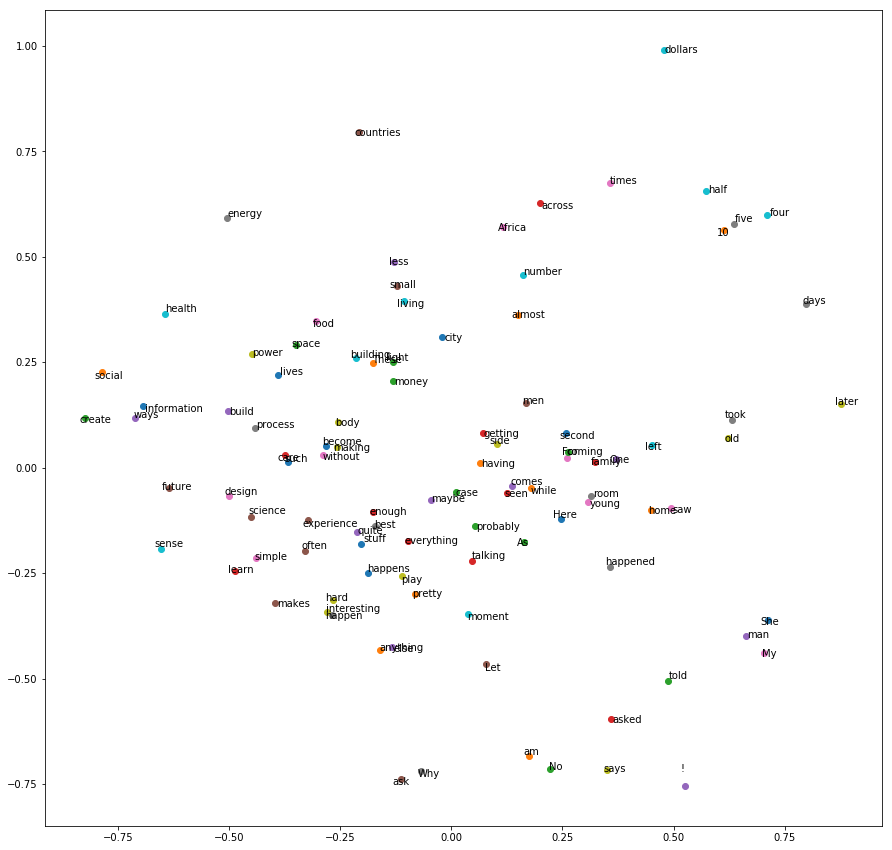

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

def pca(vocabulary, embeddings, n_points):
    np.random.seed(0)

    frequent = vocabulary[vocabulary < 2000].sort_values(ascending=False).index[:n_points]
    indices = [vocabulary.index.get_loc(word) for word in frequent]
    
    pca = PCA(n_components=2, random_state=0)
    with torch.no_grad():
        results = pca.fit_transform(embeddings[indices])
    
    plt.figure(figsize=(15, 15))
    for i in range(n_points):
        query = vocabulary.index[indices[i]]
        x, y = results[i]
        plt.scatter(x, y, label=query)
        
        # Prevent label overlapping by applying random offsets.
        offset_x = np.random.randint(-35, 12) / 2000
        offset_y = np.random.randint(-30, 15) / 2000
        
        plt.annotate(query, (x + offset_x, y + offset_y))
        
    plt.show()
    
pca(vocabulary, w_main, 100)

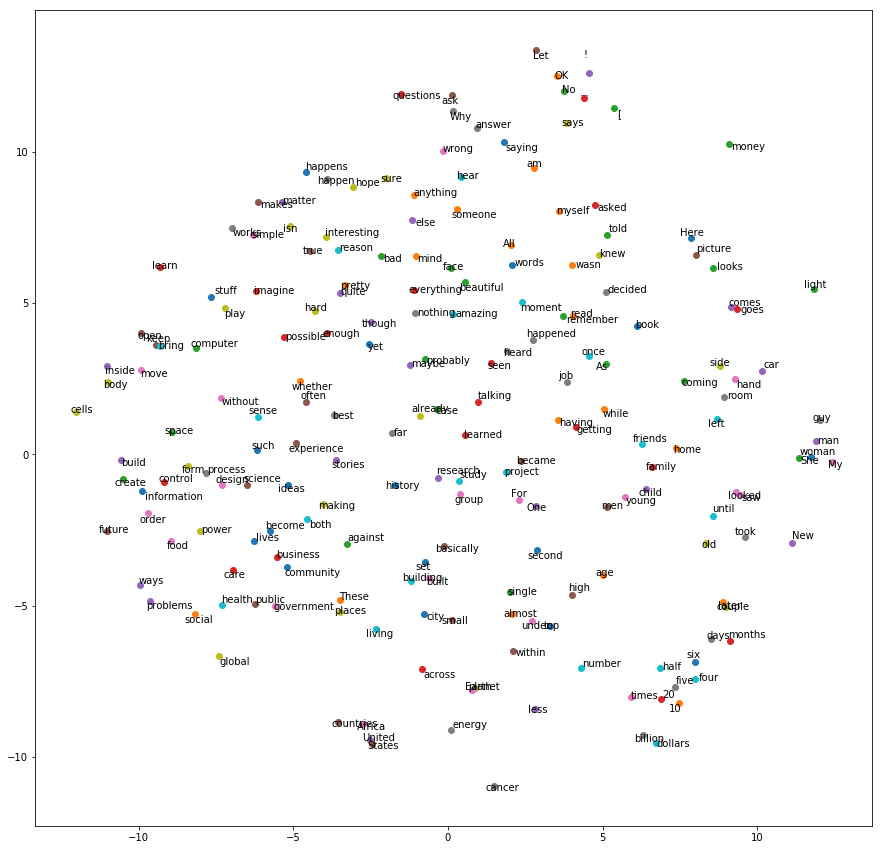

In [30]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
    
def tsne(vocabulary, embeddings, n_points):
    np.random.seed(0)

    frequent = vocabulary[vocabulary < 2000].sort_values(ascending=False).index[:n_points]
    indices = [vocabulary.index.get_loc(word) for word in frequent]

    tsne = TSNE(n_components=2, random_state=0)
    with torch.no_grad():
        results = tsne.fit_transform(embeddings[indices])
    
    plt.figure(figsize=(15, 15))
    for i in range(n_points):
        query = vocabulary.index[indices[i]]
        x, y = results[i]
        plt.scatter(x, y, label=query)
        
        # Prevent label overlapping by applying random offsets.
        offset_x = np.random.randint(-35, 12) / 100
        offset_y = np.random.randint(-30, 15) / 100
        
        plt.annotate(query, (x + offset_x, y + offset_y))
        
    plt.show()

tsne(vocabulary, w_main, 200)